Pygame rendering DISABLED. Training will run silently.
Starting Q-Learning training...
Episode 50/1000 — Tasks Processed: 100 — Total Reward: 100.89999999999993 — Tasks Dropped: 1 — Epsilon: 0.545
Episode 100/1000 — Tasks Processed: 100 — Total Reward: 101.34999999999992 — Tasks Dropped: 1 — Epsilon: 0.329
Episode 150/1000 — Tasks Processed: 100 — Total Reward: 101.5999999999999 — Tasks Dropped: 1 — Epsilon: 0.199
Episode 200/1000 — Tasks Processed: 100 — Total Reward: 101.44999999999992 — Tasks Dropped: 1 — Epsilon: 0.121
Episode 250/1000 — Tasks Processed: 100 — Total Reward: 103.5499999999999 — Tasks Dropped: 0 — Epsilon: 0.073
Episode 300/1000 — Tasks Processed: 100 — Total Reward: 103.4499999999999 — Tasks Dropped: 0 — Epsilon: 0.050
Episode 350/1000 — Tasks Processed: 100 — Total Reward: 101.64999999999992 — Tasks Dropped: 1 — Epsilon: 0.050
Episode 400/1000 — Tasks Processed: 100 — Total Reward: 103.4499999999999 — Tasks Dropped: 0 — Epsilon: 0.050
Episode 450/1000 — Tasks Proce

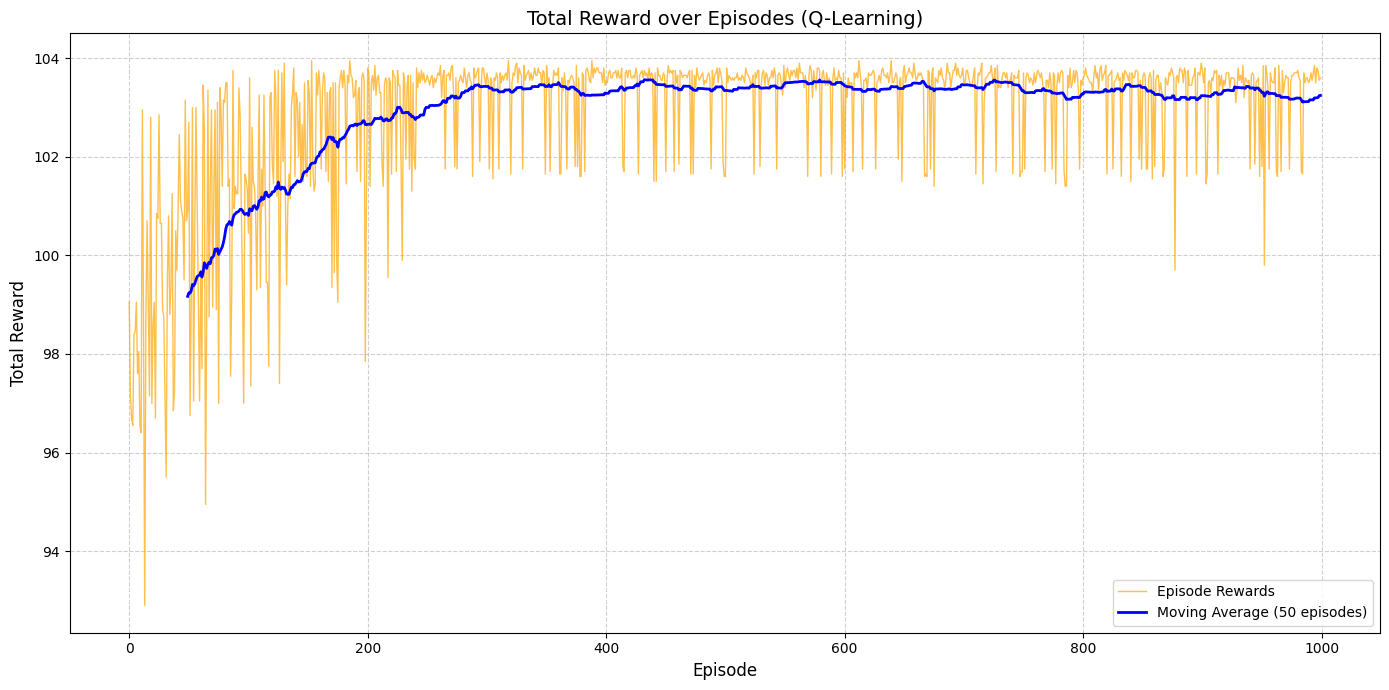

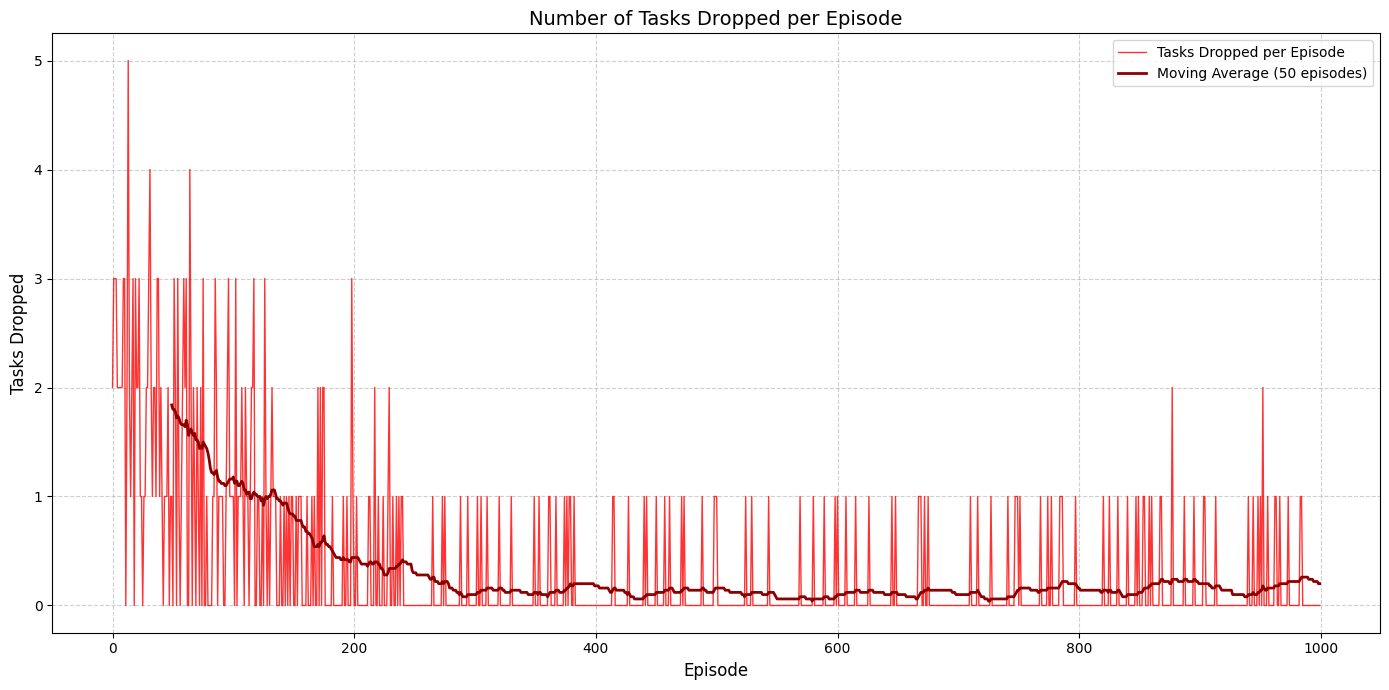


--- Final Task Schedule (from the last completed training episode) ---
 Task_ID  Priority  Action_Delay  Action_Compress  Action_Radar  Dropped  Final_TNS  Final_Pn  Original_Deadline  Original_Max_Power
       1         5             0                0             1    False       1.34        28              15.34                  33
       3         5             0                1             1    False       3.86        32              15.86                  51
       7         5             0                2             1    False       7.24        15              15.24                  17
       9         5             2                2             2    False      11.19        15              17.19                  32
      14         5             1                0             1    False      15.17        46              26.17                  54
      17         5             2                0             0    False      19.20        32              25.20                  

In [1]:
import gymnasium
from gymnasium import spaces
import numpy as np
import pandas as pd
import heapq
import pygame
import matplotlib.pyplot as plt
from collections import defaultdict

class RadarTaskSchedulerEnv(gymnasium.Env):
    metadata = {"render_modes": ["human"], "render_fps": 1}

    def __init__(self, task_file="dataset2.csv", render_mode=None):
        super(RadarTaskSchedulerEnv, self).__init__()

        self.tasks_df = pd.read_csv(task_file)
        self.num_tasks = len(self.tasks_df)

        self.priority_queue = []
        self.entry_count = 0

        self.current_task_data = None

        self.scheduled_tasks_log = []

        self.observation_space = spaces.Box(low=0, high=100, shape=(3,), dtype=np.int64)

        self.action_space = spaces.MultiDiscrete([3, 3, 3])

        self.render_mode = render_mode
        self.screen = None
        self.font = None
        self.clock = None
        self.width = 800
        self.height = 600

        self._last_info = {}
        self._last_reward = 0

    def reset(self,*, seed=None, options=None):
        super().reset(seed=seed)

        self.priority_queue = []
        self.entry_count = 0

        for index, row in self.tasks_df.iterrows():
            negative_priority = -row['Priority']
            heapq.heappush(self.priority_queue, (negative_priority, self.entry_count, row.to_dict()))
            self.entry_count += 1
        
        self.scheduled_tasks_log = []
        self._last_info = {}
        self._last_reward = 0

        obs = self._get_observation()
        
        if self.render_mode == "human":
            self._init_render()
            self.render()

        return obs, {}

    def step(self, action):
        if self.current_task_data is None:
            return np.array([0, 0, 0], dtype=np.int64), 0, True, False, {"task_dropped": False, "task_id": "N/A"}

        _priority, _entry_count, task_to_process = heapq.heappop(self.priority_queue)
        
        delay, compress, radar_choice = action
        
        tns = task_to_process['Request_Time'] + delay
        Pn = task_to_process['Init_Power'] + compress

        task_dropped = (tns > task_to_process['Deadline']) or \
                       (Pn > task_to_process['Max_Power'])

        # --- REWARD SHAPING IMPROVEMENT ---
        reward = 0.0 # Initialize reward as float

        # Base reward for success/failure
        if not task_dropped:
            reward += 1.0 # Successfully scheduled
        else:
            reward -= 1.0 # Task dropped

        # 1. Penalize nearing deadlines
        if not task_dropped: # Only apply if not already dropped by deadline
            time_to_deadline = task_to_process['Deadline'] - tns
            if time_to_deadline < 2: # Within 2 units of deadline
                reward -= 0.1 # Small penalty for cutting it close
            elif time_to_deadline < 0: # This case shouldn't happen if not task_dropped, but as safeguard
                reward -= 0.2
        # If task is dropped due to deadline, it already gets -1.0, maybe a slight additional penalty for large overshoot
        elif tns > task_to_process['Deadline'] + 5: # If deadline is grossly exceeded
             reward -= 0.2 # Additional penalty for very bad time management

        # 2. Penalize nearing max power
        if not task_dropped: # Only apply if not already dropped by power
            power_margin = task_to_process['Max_Power'] - Pn
            if power_margin < 2: # Within 2 units of max power
                reward -= 0.1 # Small penalty for using almost max power
            elif power_margin < 0: # Should not happen if not task_dropped
                reward -= 0.2
        # If task is dropped due to power, similar large overshoot penalty
        elif Pn > task_to_process['Max_Power'] + 5:
            reward -= 0.2

        # 3. Reward for using minimal delay if feasible
        # If delay_action was 0 and task was successfully scheduled (not dropped)
        if delay == 0 and not task_dropped:
            reward += 0.05 # Small bonus for optimal delay

        # 4. Reward for using minimal compression if feasible
        # If compress_action was 0 and task was successfully scheduled (not dropped by power)
        if compress == 0 and not task_dropped:
            reward += 0.05 # Small bonus for optimal power usage (minimal compression)

        # 5. Optional: Slightly higher reward for high priority tasks
        # This is very subtle and needs careful tuning to not upset overall goal
        # priority_factor = task_to_process['Priority'] / self.tasks_df['Priority'].max()
        # if not task_dropped:
        #     reward += (priority_factor * 0.01) # Small bonus
        # else:
        #     reward -= (priority_factor * 0.02) # Slightly larger penalty

        # --- END REWARD SHAPING IMPROVEMENT ---

        info = { 
            "task_id": task_to_process["Task_ID"],
            "task_dropped": task_dropped,
            "delay_action": delay,
            "compress_action": compress,
            "radar_choice_action": radar_choice,
            "calculated_tns": tns,
            "calculated_Pn": Pn,
            "original_deadline": task_to_process['Deadline'],
            "original_max_power": task_to_process['Max_Power']
        }
        self._last_info = info
        self._last_reward = reward

        self.scheduled_tasks_log.append({
            'Task_ID': task_to_process['Task_ID'],
            'Priority': task_to_process['Priority'],
            'Action_Delay': delay,
            'Action_Compress': compress,
            'Action_Radar': radar_choice,
            'Dropped': task_dropped,
            'Final_TNS': tns,
            'Final_Pn': Pn,
            'Original_Deadline': task_to_process['Deadline'],
            'Original_Max_Power': task_to_process['Max_Power']
        })

        done = not self.priority_queue

        next_obs = self._get_observation()
            
        if self.render_mode == "human":
            self.render()

        return next_obs, reward, done, False, info

    def _get_observation(self):
        if self.priority_queue:
            _priority, _entry_count, task_dict = self.priority_queue[0]
            self.current_task_data = task_dict
            return np.array([int(task_dict['Duration']), int(task_dict['Deadline']), int(task_dict['Init_Power'])], dtype=np.int64)
        else:
            self.current_task_data = None
            return np.array([0, 0, 0], dtype=np.int64)

    def _init_render(self):
        if self.screen is None:
            pygame.init()
            pygame.display.set_caption("Radar Task Scheduler")
            self.screen = pygame.display.set_mode((self.width, self.height))
            self.font = pygame.font.Font(None, 30)
            self.clock = pygame.time.Clock()

    def render(self):
        if self.render_mode != "human":
            return

        self._init_render()

        self.screen.fill((0, 0, 0))

        y_offset = 20
        self._draw_text(f"Tasks Remaining: {len(self.priority_queue)}", (255, 255, 255), y_offset)
        y_offset += 40

        if self._last_info:
            self._draw_text("--- Last Task Processed ---", (255, 255, 0), y_offset)
            y_offset += 30
            task_id = self._last_info.get('task_id')
            priority_val = 'N/A'
            if task_id and 'Task_ID' in self.tasks_df.columns and not self.tasks_df[self.tasks_df['Task_ID'] == task_id].empty:
                priority_val = self.tasks_df[self.tasks_df['Task_ID'] == task_id]['Priority'].iloc[0]

            self._draw_text(f"Task ID: {task_id} (Prio: {priority_val})", (200, 200, 200), y_offset)
            y_offset += 25
            self._draw_text(f"Action: Delay {self._last_info.get('delay_action')}, Compress {self._last_info.get('compress_action')}, Radar {self._last_info.get('radar_choice_action')}", (150, 250, 150), y_offset)
            y_offset += 25
            self._draw_text(f"TNS: {self._last_info.get('calculated_tns')} (Deadline: {self._last_info.get('original_deadline')})", (200, 200, 200), y_offset)
            y_offset += 25
            self._draw_text(f"Pn: {self._last_info.get('calculated_Pn')} (Max: {self._last_info.get('original_max_power')})", (200, 200, 200), y_offset)
            y_offset += 25
            
            task_dropped_color = (255, 0, 0) if self._last_info.get('task_dropped', False) else (0, 255, 0)
            self._draw_text(f"Dropped: {self._last_info.get('task_dropped')}", task_dropped_color, y_offset)
            y_offset += 25
            
            reward_color = (0, 255, 0) if self._last_reward == 1 else (255, 0, 0)
            self._draw_text(f"Reward: {self._last_reward}", reward_color, y_offset)
            y_offset += 40

        if self.current_task_data:
            self._draw_text("--- Next Task to Process (Highest Priority) ---", (0, 255, 255), y_offset)
            y_offset += 30
            self._draw_text(f"Task ID: {self.current_task_data['Task_ID']}", (200, 200, 200), y_offset)
            y_offset += 25
            self._draw_text(f"Priority: {self.current_task_data['Priority']}", (200, 200, 200), y_offset)
            y_offset += 25
            self._draw_text(f"Duration: {self.current_task_data['Duration']}", (200, 200, 200), y_offset)
            y_offset += 25
            self._draw_text(f"Request Time: {self.current_task_data['Request_Time']}", (200, 200, 200), y_offset)
            y_offset += 25
            self._draw_text(f"Deadline: {self.current_task_data['Deadline']}", (200, 200, 200), y_offset)
            y_offset += 25
            self._draw_text(f"Init Power: {self.current_task_data['Init_Power']}", (200, 200, 200), y_offset)
            y_offset += 25
            self._draw_text(f"Max Power: {self.current_task_data['Max_Power']}", (200, 200, 200), y_offset)
            y_offset += 25
        else:
            self._draw_text("--- All tasks processed ---", (0, 255, 0), y_offset)

        pygame.display.flip()
        self.clock.tick(self.metadata["render_fps"])

    def _draw_text(self, text, color, y):
        text_surface = self.font.render(text, True, color)
        text_rect = text_surface.get_rect(center=(self.width // 2, y))
        self.screen.blit(text_surface, text_rect)

    def close(self):
        if self.screen is not None:
            pygame.quit()
            self.screen = None
            self.font = None
            self.clock = None

class QLearningAgent:
    def __init__(self, state_size, action_size, alpha, gamma, epsilon, epsilon_decay, final_epsilon):
        self.q_table = defaultdict(lambda: np.zeros(action_size))
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.initial_epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon
        self.action_size = action_size
        self.state_size = state_size

    def choose_action(self, state):
        state_key = str(state)
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.action_size)
        return np.argmax(self.q_table[state_key])

    def update_q_value(self, state, action, reward, next_state):
        state_key = str(state)
        next_state_key = str(next_state)

        best_next_action = np.argmax(self.q_table[next_state_key])
        
        td_target = reward + self.gamma * self.q_table[next_state_key][best_next_action]
        
        td_error = td_target - self.q_table[state_key][action]
        
        self.q_table[state_key][action] += self.alpha * td_error

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon * self.epsilon_decay, self.final_epsilon)

if __name__ == "__main__":
    enable_rendering = input("Enable Pygame rendering during training? (Y/N): ").strip().lower()
    if enable_rendering == 'y':
        render_mode_choice = "human"
        print("Pygame rendering ENABLED. Close the Pygame window to stop training prematurely.")
    else:
        render_mode_choice = None
        print("Pygame rendering DISABLED. Training will run silently.")

    env = RadarTaskSchedulerEnv(task_file="dataset2.csv", render_mode=render_mode_choice)
    
    agent = QLearningAgent(
        state_size=3,
        action_size=27,
        alpha=0.15,
        gamma=0.95,
        epsilon=0.9,
        epsilon_decay=0.99,
        final_epsilon=0.05
    )

    def decode_action(index):
        delay = index // 9
        compress = (index % 9) // 3
        radar = index % 3
        return [delay, compress, radar]

    episodes = 1000
    reward_log = []
    task_drop_log = []

    print("Starting Q-Learning training...")

    for episode in range(episodes):
        state, info = env.reset()
        done = False
        total_reward = 0
        task_drops = 0
        episode_step_count = 0

        while not done:
            if env.render_mode == "human":
                for event in pygame.event.get():
                    if event.type == pygame.QUIT:
                        done = True
                        break
                if done:
                    break

            action_index = agent.choose_action(state)
            action = decode_action(action_index)
            
            next_state, reward, done, _, info = env.step(action)
            
            agent.update_q_value(state, action_index, reward, next_state)

            state = next_state
            total_reward += reward
            episode_step_count += 1

            if info.get('task_dropped', False):
                task_drops += 1
        
        reward_log.append(total_reward)
        task_drop_log.append(task_drops)

        agent.decay_epsilon()

        if (episode + 1) % 50 == 0 or episode == episodes - 1:
            print(f"Episode {episode+1}/{episodes} — Tasks Processed: {episode_step_count} — Total Reward: {total_reward} — Tasks Dropped: {task_drops} — Epsilon: {agent.epsilon:.3f}")

        if done and episode_step_count < env.num_tasks and env.render_mode == "human":
            print("\nPygame window closed. Stopping training prematurely.")
            break

    print("\nTraining complete!")

    window_size = 50

    if not reward_log:
        print("\nReward log is empty. No reward plot will be generated.")
    else:
        moving_avg = []
        x_moving_avg = []
        if len(reward_log) >= window_size:
            moving_avg = np.convolve(reward_log, np.ones(window_size)/window_size, mode='valid')
            x_moving_avg = range(window_size - 1, len(reward_log))

        plt.figure(figsize=(14,7))
        plt.plot(reward_log, label='Episode Rewards', color='orange', alpha=0.7, linewidth=1)
        
        if moving_avg.size > 0:
            plt.plot(x_moving_avg, moving_avg, label=f'Moving Average ({window_size} episodes)', color='blue', linewidth=2)
        
        plt.xlabel('Episode', fontsize=12)
        plt.ylabel('Total Reward', fontsize=12)
        plt.title('Total Reward over Episodes (Q-Learning)', fontsize=14)
        plt.legend(fontsize=10)
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()

    if not task_drop_log:
        print("\nTask drop log is empty. No task drop plot will be generated.")
    else:
        moving_avg_drops = []
        x_moving_avg_drops = []
        if len(task_drop_log) >= window_size:
            moving_avg_drops = np.convolve(task_drop_log, np.ones(window_size)/window_size, mode='valid')
            x_moving_avg_drops = range(window_size - 1, len(task_drop_log))

        plt.figure(figsize=(14,7))
        plt.plot(task_drop_log, label='Tasks Dropped per Episode', color='red', alpha=0.8, linewidth=1)
        
        if moving_avg_drops.size > 0:
            plt.plot(x_moving_avg_drops, moving_avg_drops, label=f'Moving Average ({window_size} episodes)', color='darkred', linewidth=2)
        
        plt.xlabel('Episode', fontsize=12)
        plt.ylabel('Tasks Dropped', fontsize=12)
        plt.title('Number of Tasks Dropped per Episode', fontsize=14)
        plt.legend(fontsize=10)
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()

    print("\n--- Final Task Schedule (from the last completed training episode) ---")
    if env.scheduled_tasks_log and len(env.scheduled_tasks_log) == env.num_tasks:
        schedule_df = pd.DataFrame(env.scheduled_tasks_log)
        print(schedule_df.to_string(index=False))
    else:
        print("The last episode might have been interrupted or did not complete all tasks.")
        print("To see a full schedule, ensure the training completes at least one full episode.")
    
    env.close()
    print("Environment closed.")

LOGGING

In [2]:
import gymnasium
from gymnasium import spaces
import numpy as np
import pandas as pd
import heapq
import pygame
import matplotlib.pyplot as plt
from collections import defaultdict

class RadarTaskSchedulerEnv(gymnasium.Env):
    metadata = {"render_modes": ["human"], "render_fps": 1}

    def __init__(self, task_file="dataset2.csv", render_mode=None):
        super(RadarTaskSchedulerEnv, self).__init__()

        self.tasks_df = pd.read_csv(task_file)
        self.num_tasks = len(self.tasks_df)

        self.priority_queue = []
        self.entry_count = 0

        self.current_task_data = None

        self.scheduled_tasks_log = []

        # Observation space: [Duration, Deadline, Init_Power]
        # Assuming these values can range up to 100 based on typical dataset values
        self.observation_space = spaces.Box(low=0, high=100, shape=(3,), dtype=np.int64)

        # Action space: [delay (0,1,2), compress (0,1,2), radar_choice (0,1,2)]
        # This gives 3*3*3 = 27 possible discrete actions
        self.action_space = spaces.MultiDiscrete([3, 3, 3])

        self.render_mode = render_mode
        self.screen = None
        self.font = None
        self.clock = None
        self.width = 800
        self.height = 600

        self._last_info = {}
        self._last_reward = 0

    def reset(self,*, seed=None, options=None):
        super().reset(seed=seed)

        self.priority_queue = []
        self.entry_count = 0

        # Populate priority queue: (negative_priority, entry_count, task_data_dict)
        # Using negative priority to make heapq a max-priority queue
        for index, row in self.tasks_df.iterrows():
            negative_priority = -row['Priority']
            heapq.heappush(self.priority_queue, (negative_priority, self.entry_count, row.to_dict()))
            self.entry_count += 1
        
        self.scheduled_tasks_log = []
        self._last_info = {}
        self._last_reward = 0

        obs = self._get_observation()
        
        if self.render_mode == "human":
            self._init_render()
            self.render()

        return obs, {}

    def step(self, action):
        # If no more tasks, return a terminal state
        if not self.priority_queue:
            return np.array([0, 0, 0], dtype=np.int64), 0, True, False, {"task_dropped": False, "task_id": "N/A", "message": "No tasks left to process."}

        _priority, _entry_count, task_to_process = heapq.heappop(self.priority_queue)
        
        delay, compress, radar_choice = action
        
        # Calculate new time and power based on actions
        tns = task_to_process['Request_Time'] + delay
        Pn = task_to_process['Init_Power'] + compress

        # Determine if task is dropped
        task_dropped = (tns > task_to_process['Deadline']) or \
                       (Pn > task_to_process['Max_Power'])

        # --- REWARD SHAPING IMPROVEMENT ---
        reward = 0.0 # Initialize reward as float

        # Base reward for success/failure
        if not task_dropped:
            reward += 1.0 # Successfully scheduled
        else:
            reward -= 1.0 # Task dropped

        # 1. Penalize nearing deadlines
        if not task_dropped: # Only apply if not already dropped by deadline
            time_to_deadline = task_to_process['Deadline'] - tns
            if time_to_deadline < 2: # Within 2 units of deadline
                reward -= 0.1 # Small penalty for cutting it close
            elif time_to_deadline < 0: # This case shouldn't happen if not task_dropped, but as safeguard
                reward -= 0.2
        # If task is dropped due to deadline, it already gets -1.0, maybe a slight additional penalty for large overshoot
        elif tns > task_to_process['Deadline'] + 5: # If deadline is grossly exceeded
             reward -= 0.2 # Additional penalty for very bad time management

        # 2. Penalize nearing max power
        if not task_dropped: # Only apply if not already dropped by power
            power_margin = task_to_process['Max_Power'] - Pn
            if power_margin < 2: # Within 2 units of max power
                reward -= 0.1 # Small penalty for using almost max power
            elif power_margin < 0: # Should not happen if not task_dropped
                reward -= 0.2
        # If task is dropped due to power, similar large overshoot penalty
        elif Pn > task_to_process['Max_Power'] + 5:
            reward -= 0.2

        # 3. Reward for using minimal delay if feasible
        # If delay_action was 0 and task was successfully scheduled (not dropped)
        if delay == 0 and not task_dropped:
            reward += 0.05 # Small bonus for optimal delay

        # 4. Reward for using minimal compression if feasible
        # If compress_action was 0 and task was successfully scheduled (not dropped by power)
        if compress == 0 and not task_dropped:
            reward += 0.05 # Small bonus for optimal power usage (minimal compression)

        # 5. Optional: Slightly higher reward for high priority tasks
        # This is very subtle and needs careful tuning to not upset overall goal
        # priority_factor = task_to_process['Priority'] / self.tasks_df['Priority'].max()
        # if not task_dropped:
        #     reward += (priority_factor * 0.01) # Small bonus
        # else:
        #     reward -= (priority_factor * 0.02) # Slightly larger penalty

        # --- END REWARD SHAPING IMPROVEMENT ---

        info = { 
            "task_id": task_to_process["Task_ID"],
            "task_dropped": task_dropped,
            "delay_action": delay,
            "compress_action": compress,
            "radar_choice_action": radar_choice,
            "calculated_tns": tns,
            "calculated_Pn": Pn,
            "original_deadline": task_to_process['Deadline'],
            "original_max_power": task_to_process['Max_Power']
        }
        self._last_info = info
        self._last_reward = reward

        self.scheduled_tasks_log.append({
            'Task_ID': task_to_process['Task_ID'],
            'Priority': task_to_process['Priority'],
            'Action_Delay': delay,
            'Action_Compress': compress,
            'Action_Radar': radar_choice,
            'Dropped': task_dropped,
            'Final_TNS': tns,
            'Final_Pn': Pn,
            'Original_Deadline': task_to_process['Deadline'],
            'Original_Max_Power': task_to_process['Max_Power']
        })

        done = not self.priority_queue

        next_obs = self._get_observation()
            
        if self.render_mode == "human":
            self.render()

        return next_obs, reward, done, False, info

    def _get_observation(self):
        if self.priority_queue:
            # The observation should be of the next task that will be processed
            _priority, _entry_count, task_dict = self.priority_queue[0] 
            self.current_task_data = task_dict
            # Ensure observation elements are within the defined bounds if necessary, 
            # or adjust observation_space if values can exceed 100
            return np.array([int(task_dict['Duration']), int(task_dict['Deadline']), int(task_dict['Init_Power'])], dtype=np.int64)
        else:
            self.current_task_data = None
            return np.array([0, 0, 0], dtype=np.int64)

    def _init_render(self):
        if self.screen is None:
            pygame.init()
            pygame.display.set_caption("Radar Task Scheduler")
            self.screen = pygame.display.set_mode((self.width, self.height))
            self.font = pygame.font.Font(None, 30)
            self.clock = pygame.time.Clock()

    def render(self):
        if self.render_mode != "human":
            return

        self._init_render()

        self.screen.fill((0, 0, 0)) # Black background

        y_offset = 20
        self._draw_text(f"Tasks Remaining: {len(self.priority_queue)}", (255, 255, 255), y_offset)
        y_offset += 40

        if self._last_info:
            self._draw_text("--- Last Task Processed ---", (255, 255, 0), y_offset) # Yellow
            y_offset += 30
            task_id = self._last_info.get('task_id')
            priority_val = 'N/A'
            # Safely get priority for the last processed task from the original dataframe
            if task_id is not None and not self.tasks_df[self.tasks_df['Task_ID'] == task_id].empty:
                priority_val = self.tasks_df[self.tasks_df['Task_ID'] == task_id]['Priority'].iloc[0]

            self._draw_text(f"Task ID: {task_id} (Prio: {priority_val})", (200, 200, 200), y_offset)
            y_offset += 25
            self._draw_text(f"Action: Delay {self._last_info.get('delay_action')}, Compress {self._last_info.get('compress_action')}, Radar {self._last_info.get('radar_choice_action')}", (150, 250, 150), y_offset) # Light Green
            y_offset += 25
            self._draw_text(f"TNS: {self._last_info.get('calculated_tns')} (Deadline: {self._last_info.get('original_deadline')})", (200, 200, 200), y_offset)
            y_offset += 25
            self._draw_text(f"Pn: {self._last_info.get('calculated_Pn')} (Max: {self._last_info.get('original_max_power')})", (200, 200, 200), y_offset)
            y_offset += 25
            
            task_dropped_color = (255, 0, 0) if self._last_info.get('task_dropped', False) else (0, 255, 0) # Red if dropped, Green if not
            self._draw_text(f"Dropped: {self._last_info.get('task_dropped')}", task_dropped_color, y_offset)
            y_offset += 25
            
            reward_color = (0, 255, 0) if self._last_reward > 0 else (255, 0, 0) if self._last_reward < 0 else (255, 255, 255)
            self._draw_text(f"Reward: {self._last_reward:.2f}", reward_color, y_offset) # Display reward with 2 decimal places
            y_offset += 40

        if self.current_task_data:
            self._draw_text("--- Next Task to Process (Highest Priority) ---", (0, 255, 255), y_offset) # Cyan
            y_offset += 30
            self._draw_text(f"Task ID: {self.current_task_data['Task_ID']}", (200, 200, 200), y_offset)
            y_offset += 25
            self._draw_text(f"Priority: {self.current_task_data['Priority']}", (200, 200, 200), y_offset)
            y_offset += 25
            self._draw_text(f"Duration: {self.current_task_data['Duration']}", (200, 200, 200), y_offset)
            y_offset += 25
            self._draw_text(f"Request Time: {self.current_task_data['Request_Time']}", (200, 200, 200), y_offset)
            y_offset += 25
            self._draw_text(f"Deadline: {self.current_task_data['Deadline']}", (200, 200, 200), y_offset)
            y_offset += 25
            self._draw_text(f"Init Power: {self.current_task_data['Init_Power']}", (200, 200, 200), y_offset)
            y_offset += 25
            self._draw_text(f"Max Power: {self.current_task_data['Max_Power']}", (200, 200, 200), y_offset)
            y_offset += 25
        else:
            self._draw_text("--- All tasks processed ---", (0, 255, 0), y_offset) # Green

        pygame.display.flip()
        self.clock.tick(self.metadata["render_fps"])

    def _draw_text(self, text, color, y):
        text_surface = self.font.render(text, True, color)
        text_rect = text_surface.get_rect(center=(self.width // 2, y))
        self.screen.blit(text_surface, text_rect)

    def close(self):
        if self.screen is not None:
            pygame.quit()
            self.screen = None
            self.font = None
            self.clock = None

class QLearningAgent:
    def __init__(self, state_size, action_size, alpha, gamma, epsilon, epsilon_decay, final_epsilon):
        self.q_table = defaultdict(lambda: np.zeros(action_size))
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.initial_epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon
        self.action_size = action_size
        self.state_size = state_size

    def choose_action(self, state):
        state_key = str(state) # Convert numpy array state to string for dictionary key
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.action_size)
        return np.argmax(self.q_table[state_key])

    def update_q_value(self, state, action, reward, next_state):
        state_key = str(state)
        next_state_key = str(next_state)

        # Q-learning update rule: Q(s,a) = Q(s,a) + alpha * [reward + gamma * max(Q(s',a')) - Q(s,a)]
        best_next_action = np.argmax(self.q_table[next_state_key])
        
        td_target = reward + self.gamma * self.q_table[next_state_key][best_next_action]
        
        td_error = td_target - self.q_table[state_key][action]
        
        self.q_table[state_key][action] += self.alpha * td_error

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon * self.epsilon_decay, self.final_epsilon)

if __name__ == "__main__":
    enable_rendering = input("Enable Pygame rendering during training? (Y/N): ").strip().lower()
    if enable_rendering == 'y':
        render_mode_choice = "human"
        print("Pygame rendering ENABLED. Close the Pygame window to stop training prematurely.")
    else:
        render_mode_choice = None
        print("Pygame rendering DISABLED. Training will run silently.")

    env = RadarTaskSchedulerEnv(task_file="dataset2.csv", render_mode=render_mode_choice)
    
    agent = QLearningAgent(
        state_size=3, # (Duration, Deadline, Init_Power)
        action_size=27, # 3 (delay) * 3 (compress) * 3 (radar_choice)
        alpha=0.15,
        gamma=0.95,
        epsilon=0.9,
        epsilon_decay=0.99,
        final_epsilon=0.05
    )

    # Helper function to decode the single action index back into its components
    def decode_action(index):
        # Action space is MultiDiscrete([3, 3, 3])
        # index = delay * (3*3) + compress * 3 + radar
        delay = index // 9
        compress = (index % 9) // 3
        radar = index % 3
        return [delay, compress, radar]

    episodes = 1000
    reward_log = []
    task_drop_log = []

    output_filename = "q_learning_results.txt"
    with open(output_filename, "w") as f_out:
        f_out.write("--- Q-Learning Training Log ---\n\n")

        print("Starting Q-Learning training...")
        f_out.write("Starting Q-Learning training...\n\n")

        for episode in range(episodes):
            state, info = env.reset()
            done = False
            total_reward = 0
            task_drops = 0
            episode_step_count = 0

            # Handle Pygame window closing during training
            if env.render_mode == "human":
                for event in pygame.event.get():
                    if event.type == pygame.QUIT:
                        done = True # Set done to True to exit the episode loop
                        break # Exit the event loop
                if done: # If Pygame window was closed
                    print("\nPygame window closed. Stopping training prematurely.")
                    f_out.write("\nPygame window closed. Stopping training prematurely.\n")
                    break # Exit the main training loop

            while not done:
                # This check is repeated because `done` might be set by pygame.QUIT within the loop
                if env.render_mode == "human":
                    for event in pygame.event.get():
                        if event.type == pygame.QUIT:
                            done = True
                            break
                    if done:
                        break

                action_index = agent.choose_action(state)
                action = decode_action(action_index)
                
                next_state, reward, done, _, info = env.step(action)
                
                # Only update Q-value if the task was actually processed (not the initial [0,0,0] state before any task)
                if env.current_task_data is not None or episode_step_count > 0:
                    agent.update_q_value(state, action_index, reward, next_state)

                state = next_state
                total_reward += reward
                episode_step_count += 1

                if info.get('task_dropped', False):
                    task_drops += 1
            
            reward_log.append(total_reward)
            task_drop_log.append(task_drops)

            agent.decay_epsilon()

            if (episode + 1) % 50 == 0 or episode == episodes - 1:
                log_message = f"Episode {episode+1}/{episodes} — Tasks Processed: {episode_step_count} — Total Reward: {total_reward:.2f} — Tasks Dropped: {task_drops} — Epsilon: {agent.epsilon:.3f}"
                print(log_message)
                f_out.write(log_message + "\n")

                # 1. Print Q-table (selective print for readability)
                f_out.write(f"\n--- Q-Table after Episode {episode+1} (first 10 entries) ---\n")
                q_table_entries_printed = 0
                for s_key, a_values in agent.q_table.items():
                    f_out.write(f"State: {s_key}\n")
                    # Print Q-values for each action, formatted
                    action_values_str = ", ".join([f"{val:.2f}" for val in a_values])
                    f_out.write(f"  Q-values: [{action_values_str}]\n")
                    q_table_entries_printed += 1
                    if q_table_entries_printed >= 10: # Limit output to avoid massive files
                        f_out.write("  ...\n")
                        break
                f_out.write("---\n\n")

    print("\nTraining complete!")
    with open(output_filename, "a") as f_out: # Open in append mode for final results
        f_out.write("\nTraining complete!\n")

        window_size = 50

        # Plotting Rewards
        if not reward_log:
            print("\nReward log is empty. No reward plot will be generated.")
            f_out.write("\nReward log is empty. No reward plot will be generated.\n")
        else:
            moving_avg = []
            x_moving_avg = []
            if len(reward_log) >= window_size:
                moving_avg = np.convolve(reward_log, np.ones(window_size)/window_size, mode='valid')
                x_moving_avg = range(window_size - 1, len(reward_log))

            plt.figure(figsize=(14,7))
            plt.plot(reward_log, label='Episode Rewards', color='orange', alpha=0.7, linewidth=1)
            
            if moving_avg.size > 0:
                plt.plot(x_moving_avg, moving_avg, label=f'Moving Average ({window_size} episodes)', color='blue', linewidth=2)
            
            plt.xlabel('Episode', fontsize=12)
            plt.ylabel('Total Reward', fontsize=12)
            plt.title('Total Reward over Episodes (Q-Learning)', fontsize=14)
            plt.legend(fontsize=10)
            plt.grid(True, linestyle='--', alpha=0.6)
            plt.tight_layout()
            plt.savefig("reward_plot.png") # Save plot to file
            # plt.show() # Remove this if you don't want to display interactively
            plt.close() # Close plot to free memory
            print(f"Reward plot saved as reward_plot.png")
            f_out.write(f"Reward plot saved as reward_plot.png\n")


        # Plotting Task Drops
        if not task_drop_log:
            print("\nTask drop log is empty. No task drop plot will be generated.")
            f_out.write("\nTask drop log is empty. No task drop plot will be generated.\n")
        else:
            moving_avg_drops = []
            x_moving_avg_drops = []
            if len(task_drop_log) >= window_size:
                moving_avg_drops = np.convolve(task_drop_log, np.ones(window_size)/window_size, mode='valid')
                x_moving_avg_drops = range(window_size - 1, len(task_drop_log))

            plt.figure(figsize=(14,7))
            plt.plot(task_drop_log, label='Tasks Dropped per Episode', color='red', alpha=0.8, linewidth=1)
            
            if moving_avg_drops.size > 0:
                plt.plot(x_moving_avg_drops, moving_avg_drops, label=f'Moving Average ({window_size} episodes)', color='darkred', linewidth=2)
            
            plt.xlabel('Episode', fontsize=12)
            plt.ylabel('Tasks Dropped', fontsize=12)
            plt.title('Number of Tasks Dropped per Episode', fontsize=14)
            plt.legend(fontsize=10)
            plt.grid(True, linestyle='--', alpha=0.6)
            plt.tight_layout()
            plt.savefig("task_drop_plot.png") # Save plot to file
            # plt.show() # Remove this if you don't want to display interactively
            plt.close() # Close plot to free memory
            print(f"Task drop plot saved as task_drop_plot.png")
            f_out.write(f"Task drop plot saved as task_drop_plot.png\n")


        f_out.write("\n\n--- Final Task Schedule (from the last completed training episode) ---\n")
        print("\n--- Final Task Schedule (from the last completed training episode) ---")
        if env.scheduled_tasks_log and len(env.scheduled_tasks_log) == env.num_tasks:
            schedule_df = pd.DataFrame(env.scheduled_tasks_log)
            f_out.write(schedule_df.to_string(index=False))
            print(schedule_df.to_string(index=False))
        else:
            f_out.write("The last episode might have been interrupted or did not complete all tasks.\n")
            f_out.write("To see a full schedule, ensure the training completes at least one full episode.\n")
            print("The last episode might have been interrupted or did not complete all tasks.")
            print("To see a full schedule, ensure the training completes at least one full episode.")
        
        # 3. Performance Metrics Table
        f_out.write("\n\n--- Performance Metrics ---\n")
        print("\n--- Performance Metrics ---")

        if env.scheduled_tasks_log:
            total_tasks_attempted = len(env.scheduled_tasks_log)
            completed_tasks = sum(1 for task in env.scheduled_tasks_log if not task['Dropped'])
            dropped_tasks_count = sum(1 for task in env.scheduled_tasks_log if task['Dropped'])

            if total_tasks_attempted > 0:
                percent_tasks_completed = (completed_tasks / total_tasks_attempted) * 100
                percent_tasks_dropped = (dropped_tasks_count / total_tasks_attempted) * 100
            else:
                percent_tasks_completed = 0.0
                percent_tasks_dropped = 0.0

            metrics = {
                "Total Tasks in Dataset": env.num_tasks,
                "Tasks Attempted (in last episode)": total_tasks_attempted,
                "Tasks Successfully Completed": completed_tasks,
                "Tasks Dropped": dropped_tasks_count,
                "Percentage of Tasks Completed": f"{percent_tasks_completed:.2f}%",
                "Percentage of Tasks Dropped": f"{percent_tasks_dropped:.2f}%"
            }

            metrics_df = pd.DataFrame(metrics.items(), columns=['Metric', 'Value'])
            f_out.write(metrics_df.to_string(index=False))
            print(metrics_df.to_string(index=False))
        else:
            f_out.write("No tasks were processed in the last completed episode to calculate metrics.\n")
            print("No tasks were processed in the last completed episode to calculate metrics.")

    env.close()
    print("Environment closed.")

Pygame rendering DISABLED. Training will run silently.
Starting Q-Learning training...
Episode 50/1000 — Tasks Processed: 100 — Total Reward: 98.85 — Tasks Dropped: 2 — Epsilon: 0.545
Episode 100/1000 — Tasks Processed: 100 — Total Reward: 102.75 — Tasks Dropped: 0 — Epsilon: 0.329
Episode 150/1000 — Tasks Processed: 100 — Total Reward: 102.55 — Tasks Dropped: 0 — Epsilon: 0.199
Episode 200/1000 — Tasks Processed: 100 — Total Reward: 102.70 — Tasks Dropped: 0 — Epsilon: 0.121
Episode 250/1000 — Tasks Processed: 100 — Total Reward: 100.70 — Tasks Dropped: 1 — Epsilon: 0.073
Episode 300/1000 — Tasks Processed: 100 — Total Reward: 100.85 — Tasks Dropped: 1 — Epsilon: 0.050
Episode 350/1000 — Tasks Processed: 100 — Total Reward: 102.70 — Tasks Dropped: 0 — Epsilon: 0.050
Episode 400/1000 — Tasks Processed: 100 — Total Reward: 102.65 — Tasks Dropped: 0 — Epsilon: 0.050
Episode 450/1000 — Tasks Processed: 100 — Total Reward: 100.80 — Tasks Dropped: 1 — Epsilon: 0.050
Episode 500/1000 — Tasks